In [1]:
### library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.stats import norm, multivariate_normal, chi2, invwishart, truncnorm
from numpy.linalg import inv
from numpy import matmul

import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True)

c:\Users\wndus\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Q1

## (d)

#### 1. Basic setting
- $X = diag(X_1, \dots, X_m) \in \mathbb{R}^{N \times md}$  
- $\beta = (\beta_1, \dots, \beta_{m})' \in \mathbb{R}^{md}$  
    $\beta_j \sim N_d(\mu_{\beta}, \Sigma_{\beta}) \in \mathbb{R}^d$ where $\mu_{\beta}=(0.5, 1), \Sigma_{\beta} = [2, 1.9, 1.9, 2]$ and $j=1, \dots, 30$  
- $y = (y_1, \dots, y_{m})' \in \mathbb{R}^N \sim \text{N}_N \left( X\beta, \sigma^2 \text{I}_N \right)$  

#### 2. prior
- Give vague prior $\mu_{\beta}$ and $\sigma^2$  
- $\mu_{\beta} \sim \text{N}_2 \left( \xi, \Omega \right) \in \mathbb{R}^2$  
- $\sigma^2 \sim \text{Inv-}\chi^2 \left( \nu, \tau^2 \right) \in \mathbb{R}$  => $\sigma^2 \sim \text{Inv-} \chi^2(3, 10`)$ 
- $\Sigma_{\beta} \sim \text{Wishart}\left(\Psi^{-1}, \rho \right) \in \mathbb{R}^{2 \times 2}$ => $\mu_{\beta} \sim \text{N}_d(0, 10 I_d)$ 
   
#### 3. full conditional distribution
- $\beta_j|\sigma^2, \mu_{\beta}, \Sigma_{\beta}, y \sim \text{N}_{2} \left( \frac{1}{\sigma^2}(X_j'X_j + \Sigma_{\beta}^{-1})^{-1}(\frac{1}{\sigma^2}y_j' X_j + \mu_{\beta}' \Sigma_{\beta}^{-1})', (\frac{1}{\sigma^2}X_j'X_j + \Sigma_{\beta}^{-1})^{-1}       \right) \in \mathbb{R}^{2}$  
- $\sigma^2 | \beta, \mu_{\beta}, \Sigma_{\beta}, y \sim \text{Inv-}\chi^2 \left(N + \nu, \frac{1}{N + \nu}(y-X\beta)'(y-X\beta) + \nu \tau^2 \right) \in \mathbb{R}$  
- $\mu_{\beta} | \beta, \sigma^2, \Sigma_{\beta}, y \sim \text{N}_{10} \left((m \Sigma_{\beta}^{-1} + \Omega^{-1})^{-1}(\sum_{j=1}^{30}{(\beta_j' \Sigma_{\beta}^{-1}}) + \xi' \Omega^{-1})', (m \Sigma_{\beta}^{-1} + \Omega^{-1})^{-1}\right) \in \mathbb{R}^2$  
- $\Sigma_{\beta} | \beta, \sigma^2 \mu_{\beta}, y \sim \text{Inv-Wishart}\left( \sum_{j=1}^{30}(\beta_j - \mu_{\beta})(\beta_j - \mu_{\beta})') + \Psi, m + \rho \right)$  

In [2]:
## Data generation
np.random.seed(42)  # Set a random seed for reproducibility

# Setting
m = 30   # number of treatment group
nj = 10  # number of observation of j-th group (equally)
d = 2    # dimension of beta
N = m * nj
sig2_true = 0.5
mu_beta_true = np.array([0.5, 1])
cov_beta_true = np.array([[2, 1.9], [1.9, 2]])

# Generate data - Design matrix X
X = np.zeros(shape=(N, m*d))
for j in range(m):
    Xj = np.ones(shape=(nj, d))
    Xj[:, 1] = np.random.uniform(0, 1, nj) 
    X[nj*j:nj*(j+1), d*j:d*(j+1)] = Xj

# Generate data - beta
beta_true = np.zeros(m*d)
for j in range(m):
    betaj = np.random.multivariate_normal(mu_beta_true, cov_beta_true)
    beta_true[d*j:d*(j+1)] = betaj

# Generate data - y
mu_y = np.matmul(X, beta_true)
cov_y = sig2_true * np.identity(N)
y =  np.random.multivariate_normal(mu_y, cov_y)

### i) For all j = 1,...,m, draw straightlines $[1, t]' \beta_j$ as a function of $t \in (0, 1)$. [This tells us how the subject-specific mean of y,$E(y_j, \beta_j)$ looks like as a function of t.]

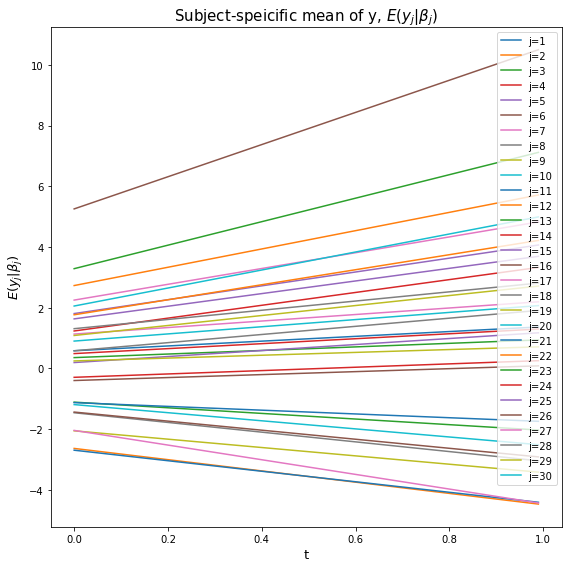

In [3]:
t = np.arange(0, 1, 0.01)

matrix = np.ones((len(t), 2))
matrix[:, 1] = t

plt.figure(figsize=(8, 8))
for j in range(m):
    plt.plot(t, np.matmul(matrix, beta_true[2*j:2*(j+1)]), label=f'j={j+1}')
plt.title(f'Subject-speicific mean of y, $E(y_j| \\beta_j)$', fontsize=15)
plt.xlabel('t', fontsize=13)
plt.ylabel(f'$E(y_j| \\beta_j)$', fontsize=13)
plt.legend()
plt.tight_layout()
plt.savefig('Q1_d_1.png')
plt.show()

### ii) Note that we can insert a step for generating replicated data $y_{rep}$, which can be used for the posterior predictive check, into the the Gibbs sampler constructed in (b). Using $\rho = d + 1, \Psi = I_d$ and hyperparameters that make the priors for $\mu_{\beta}$ and $\sigma^2$ vague, program and run the sampler to obtain the posterior distirubiton and the predictive distribution $p(y^{rep}|y)$. Draw the marginal posterior distribution for $\mu_{\beta}, \Sigma_{\beta}, \text{and } \sigma^2$ (histograms), and discuss the results.

In [4]:
#########################################################################
# Helper function                                                       #
# - Functions for sampling                                              #
#########################################################################
def sampling_beta(X, y, sig2, mu_beta, cov_beta, m, d):
    """ Sampling beta from full conditional posterior ~ MVN """

    mvn_samples = np.ones(m*d)
    for j in range(m):
        Xj = X[nj * j : nj * (j+1), d * j:d * (j+1)]
        yj = y[nj * j : nj * (j+1)]
        cov = inv((matmul(Xj.T, Xj) / sig2) + inv(cov_beta))
        mean = np.matmul(cov, (matmul(yj.T, Xj) / sig2 + matmul(mu_beta.T, inv(cov_beta))).T)
        
        mvn_sample = np.random.multivariate_normal(mean, cov)
        mvn_samples[d*j:d*(j+1)] = mvn_sample
    
    return mvn_samples


def sampling_sig2(X, y, beta, nu, tau_squared):
    """ Draw sample from inversed chi-squared distribution with df 'nu' and scale parameter 'tau_sqaured' """

    # Assign parameters
    N = X.shape[0]
    df = N + nu
    scale = (np.matmul((y - X @ beta).T, (y - X @ beta)) + nu * tau_squared) / df

    # Random samples from chi2 and inversed, scaled 
    chi_squared_samples = chi2.rvs(df)
    inv_chi_squared_samples = (df * scale) / chi_squared_samples
 
    return inv_chi_squared_samples


def sampling_mu_beta(beta, cov_beta, xi, Omega, m, d):
    """
    Draw sample from Normal distribution.
    To give noninformative prior, choose mean to be a zero vector and cov to be diagonal matrix with large diagonal element
    """
    
    # Calculate covariance
    covariance = inv(m * inv(cov_beta) + inv(Omega))

    # Calculate mean vector \in R^d
    sum_betaj = np.zeros((d, ))
    for j in range(m):
        betaj = beta[d * j : d * (j+1)]
        sum_betaj += (betaj @ inv(cov_beta))

    mean_factor = sum_betaj + xi @ inv(Omega)
    mean_vector = covariance @ mean_factor

    mvn_samples = np.random.multivariate_normal(mean_vector, covariance)

    return mvn_samples

def sampling_cov_beta(beta, mu_beta, rho, Psi, m, d):
    """ Sampling covariance of beta from full conditional posterior, Inv-Wishart"""
    
    df = m + rho            # df
    beta_sum = np.zeros((d, d))
    for j in range(m):
        betaj = beta[d * j : d * (j+1)]
        subj = (betaj - mu_beta).reshape(-1, 1)
        beta_sum += subj @ subj.T  # outer product
    scale = beta_sum + Psi  # scale

    invwishart_samples = invwishart.rvs(df, scale)

    return invwishart_samples

def sampling_cov_beta_diag(beta, mu_beta, rho, psi2, m, d):
    """ 
    Prior on  Cov_beta s.t. Cov_beta = diag(sig2_{beta, 1}, ..., sig2_{beta, d})
    sig2_{beta, k} ~ Inv-chi2(rho, psi2) for k = 1, ..., d
    """
    # For container of diagnomal matrix; Cov_beta
    cov_beta_sample = np.zeros(d)

    ## for k-th diagonal element
    for k in range(d):
        # 1. degrees of freedom of Inv-chi2
        df = m + rho  # degrees of freedom
    
        # 2. scale parameter of Inv-chi2
        sum_beta = 0  # For scale parameters
        for j in range(m):
            beta_jk = beta[d * j : d * (j+1)][k]
            mu_beta_k = mu_beta[k]
            sum_beta += (beta_jk - mu_beta_k)**2
        scale = (sum_beta + rho * psi2) / df
        
        # 3. Sampling k-th diag element in scaled Inverse-chi-squared distribution 
        chi_squared_sample = chi2.rvs(df)  
        inv_chi_squared_sample = (df * scale) / chi_squared_sample

        cov_beta_sample[k] = inv_chi_squared_sample
    
    ## Make as diagnoal matrix
    cov_beta_sample = np.diag(cov_beta_sample)

    return cov_beta_sample

def sampling_replicated(X, y, beta, sig2, m, d, nj):
    """ Sampling y replicated from theta samples """

    y_rep = np.zeros(m * nj)
    for j in range(m):
        Xj = X[nj * j : nj * (j+1), d * j : d * (j+1)]
        betaj = beta[d * j : d * (j+1)]
        yj = np.random.multivariate_normal(Xj @ betaj, sig2 * np.identity(nj))
        y_rep[nj * j : nj * (j+1)] = yj

    return y_rep

########################################################################
# Gibbs sampling for Linear Mixed model                                #
########################################################################

def mixed_effect_gibbs(X, y, hyper, n_mcmc, burn_in, cov_beta_diag_prior='True'):
    # Set hyperparameters
    m = hyper['m']; d = hyper['d']; nj = hyper['nj']
    nu = hyper['nu']; tau_squared = hyper['tau2']
    xi = hyper['xi']; Omega = hyper['Omega']
    rho = hyper['rho']; Psi = hyper['Psi']; psi2 = hyper['psi2']

    ## Object for MCMC samples
    beta_samples = np.zeros((n_mcmc+burn_in, m*d))
    sig2_samples = np.zeros(n_mcmc+burn_in)
    mu_beta_samples = np.zeros((n_mcmc+burn_in, d))
    cov_beta_samples = np.zeros((n_mcmc+burn_in, 2*d))  # Save it as flatten
    y_rep_samples = np.zeros((n_mcmc+burn_in, m*nj))

    ## Initial value
    beta_sample = np.random.normal(0, 1, m*d)
    sig2_sample = chi2.rvs(1)
    mu_beta_sample = np.random.multivariate_normal(np.zeros(d), np.identity(d))
    cov_beta_sample = invwishart.rvs(3, np.identity(d))
    
    ## MCMC chain + generating replicated data y_rep
    for i in range(n_mcmc + burn_in):
        ## At t-th iteration
        # 1. Sampling beta^(t) given sig2^(t-1), mu_beta^(t-1), cov_beta^(t-1), y
        beta_sample = sampling_beta(X, y, sig2_sample, mu_beta_sample, cov_beta_sample, m, d)

        # 2. Sampling sig2^(t) given beta^(t), mu_beta^(t-1), cov_beta^(t-1), y
        sig2_sample = sampling_sig2(X, y, beta_sample, nu, tau_squared)

        # 3. Sampling mu_beta^(t) given beta^(t), sig2^(t), cov_beta^(t-1), y
        mu_beta_sample = sampling_mu_beta(beta_sample, cov_beta_sample, xi, Omega, m, d)

        # 4. Sampling cov_beta^(t) given beta^(t), sig2^(t), mu_beta^(t), y
        if cov_beta_diag_prior == True:
            cov_beta_sample = sampling_cov_beta(beta_sample, mu_beta_sample, rho, Psi, m, d)
        else:
            cov_beta_sample = sampling_cov_beta_diag(beta_sample, mu_beta_sample, rho, psi2, m, d)

        # 5. Generating replicated data y_rep
        y_rep_sample = sampling_replicated(X, y, beta_sample, sig2_sample, m, d, nj)

        ## Save in chain
        beta_samples[i] = beta_sample
        sig2_samples[i] = sig2_sample
        mu_beta_samples[i] = mu_beta_sample
        cov_beta_samples[i] = cov_beta_sample.flatten()
        y_rep_samples[i] = y_rep_sample
    
    ## Burn-in
    beta_samples = beta_samples[burn_in:, :]
    sig2_samples = sig2_samples[burn_in:]
    mu_beta_samples = mu_beta_samples[burn_in:, :]
    cov_beta_samples = cov_beta_samples[burn_in:, :]
    y_rep_samples = y_rep_samples[burn_in:, :]
    
    return beta_samples, sig2_samples, mu_beta_samples, cov_beta_samples, y_rep_samples

#### Prior on $\Sigma_{\beta}$

In [5]:
########################################################################
# Run MCMC function                                                    #
########################################################################
m, d, nj, N = 30, 2, 10, 300

# Hyperparameters
hyper = dict()
hyper['m'] = 30
hyper['d'] = 2
hyper['nj'] = 10
hyper['nu'] = 3                        # df of Inv-chi2
hyper['tau2'] = 10                     # scale of Inv-chi2
hyper['xi'] = np.zeros(d)              # mean of MVN
hyper['Omega'] =  10 * np.identity(d)  # cov of MVN
hyper['rho'] = d + 1                   # df of Inv-Wishart
hyper['Psi'] = np.identity(d)          # scale matrix fo Inv-Wishart
hyper['psi2'] = 10

n_mcmc = 10000; burn_in = n_mcmc // 2
beta_samples, sig2_samples, mu_beta_samples, cov_beta_samples, y_rep_samples = mixed_effect_gibbs(X, y, hyper, n_mcmc, burn_in, True)

True values
mu_beta: [0.5 1. ]
cov_beta: 
 [[2.  1.9]
 [1.9 2. ]]
sigma^2: 0.5 

The means of MCMC samples
mu_beta:  [0.44243912 0.69901112]
cov_beta: 
 [[3.25474284 3.21958513]
 [3.21958513 3.7233238 ]]
sigma^2: 0.5780527115203976


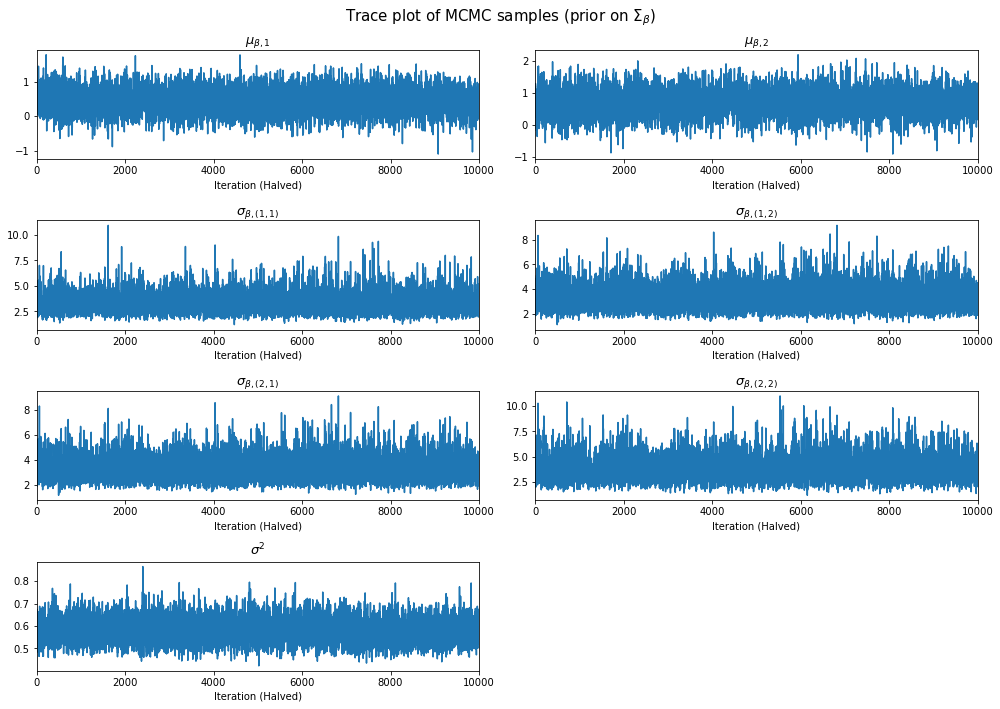

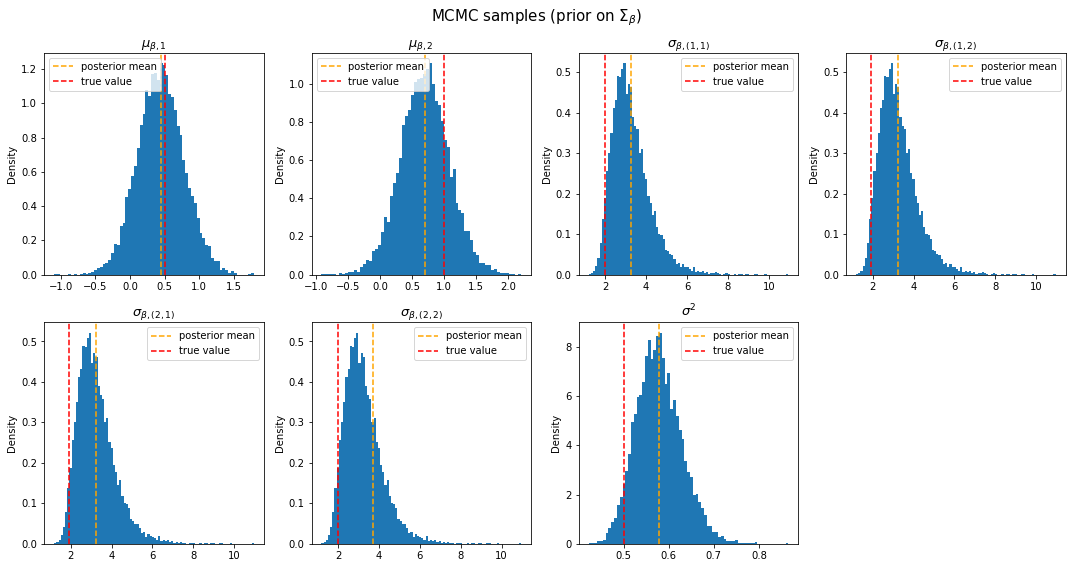

In [10]:
########################################################################
# diagnostics and histogram                                            #
########################################################################

# 1. mean
print('True values')
print(f'mu_beta: {mu_beta_true}')
print(f'cov_beta: \n {cov_beta_true}')
print(f'sigma^2: {sig2_true} \n')

print('The means of MCMC samples')
print(f'mu_beta:  {np.mean(mu_beta_samples, axis=0)}')
print(f'cov_beta: \n {np.mean(cov_beta_samples, axis=0).reshape(2, 2)}')
print(f'sigma^2: {np.mean(sig2_samples, axis=0)}')

# 2. Trace plot
plt.figure(figsize=(14, 10))
plotnm = 1
for i in range(2):
    plt.subplot(4, 2, plotnm)
    plt.plot(mu_beta_samples[:, i])
    plt.xlim(0, n_mcmc)
    plt.xlabel('Iteration (Halved)')
    plt.title(f'$\\mu_{{\\beta, {i+1}}}$', fontsize=13)
    plotnm += 1

temp_nm = [f'$\\sigma_{{\\beta, (1,1)}}$', f'$\\sigma_{{\\beta, (1,2)}}$', f'$\\sigma_{{\\beta, (2,1)}}$', f'$\\sigma_{{\\beta, (2,2)}}$']
for i in range(4):
    plt.subplot(4, 2, plotnm)
    plt.plot(cov_beta_samples[:, i])
    plt.xlim(0, n_mcmc)
    plt.xlabel('Iteration (Halved)')
    plt.title(temp_nm[i], fontsize=13)
    plotnm += 1

plt.subplot(4, 2, plotnm)
plt.plot(sig2_samples)
plt.xlim(0, n_mcmc)
plt.xlabel('Iteration (Halved)')
plt.title(f'$\\sigma^{{2}}$', fontsize=13)

plt.suptitle(f'Trace plot of MCMC samples (prior on $\\Sigma_{{\\beta}}$)', fontsize=15)
plt.tight_layout()
plt.savefig('Q1_d_2_prior_cov_trace.png')
plt.show()

########################################################################
# Histogram                                                            #
########################################################################
plt.figure(figsize=(15, 8))
plotnm = 1
for i in range(2):
    plt.subplot(2, 4, plotnm)
    plt.hist(mu_beta_samples[:, i], bins='auto', density=True)
    plt.axvline(np.mean(mu_beta_samples, axis=0)[i], color='orange', linestyle='dashed', label='posterior mean')
    plt.axvline(mu_beta_true[i], color='red', linestyle='dashed', label='true value')
    plt.ylabel('Density')
    plt.title(f'$\\mu_{{\\beta, {i+1}}}$', fontsize=13)
    plt.legend()
    plotnm += 1

temp_nm = [f'$\\sigma_{{\\beta, (1,1)}}$', f'$\\sigma_{{\\beta, (1,2)}}$', f'$\\sigma_{{\\beta, (2,1)}}$', f'$\\sigma_{{\\beta, (2,2)}}$']
for i in range(4):
    plt.subplot(2, 4, plotnm)
    plt.hist(cov_beta_samples[:, 0], bins='auto', density=True)
    plt.axvline(np.mean(cov_beta_samples, axis=0)[i], color='orange', linestyle='dashed', label='posterior mean')
    plt.axvline(cov_beta_true.flatten()[i], color='red', linestyle='dashed', label='true value')
    plt.ylabel('Density')
    plt.title(temp_nm[i], fontsize=13)
    plt.legend()
    plotnm += 1

plt.subplot(2, 4, plotnm)
plt.hist(sig2_samples, bins='auto', density=True)
plt.axvline(np.mean(sig2_samples), color='orange', linestyle='dashed', label='posterior mean')
plt.axvline(sig2_true, color='red', linestyle='dashed', label='true value')
plt.ylabel('Density')
plt.title(f'$\\sigma^{{2}}$', fontsize=13)
plt.legend()

plt.suptitle(f'MCMC samples (prior on $\\Sigma_{{\\beta}}$)', fontsize=15)
plt.tight_layout()
plt.savefig('Q1_d_2_prior_cov_hist.png')
plt.show()

### iii) Conduct the posterior predictive check using some test quantities $T(y, \theta)$. You may be eligible for extra credit if you enrich your answer using other test quantities which are reasonable for our model. Discuss the results.

#### Posterior predictive check
1. Generating replicated data $y^{rep}$ (Contained in gibbs sampler)
    - $p(y^{rep} | y) = \int p(y^{rep}|\theta)p(\theta|y)$
    - sampling $y^{rep (s)}$ using $\theta^{(s)}$ in $s$ iteration -> Get posterior simulations of $(\theta^{(s)}, y^{rep})$
2. Compare graphical plots such as the distribution of $y$ and $y^{rep}$
3. Conduct the posterior predictive check using residual teste quantitiy for regression
    - $p_B = \int \int \mathbb{1}_{T(y^{rep}|\theta) \geq T(y|\theta)} p(y^{rep} | \theta) p (\theta | y) dy^{rep} d\theta  = \mathbb{E} \left( \mathbb{1}_{T(y^{rep}|\theta) \geq T(y|\theta)} \right) \approx \frac{1}{N}\sum_{s=1}^{S}\mathbb{1}_{T(y^{rep (s)}|\theta^{(s)} \geq T(y|\theta^{(s)})}$

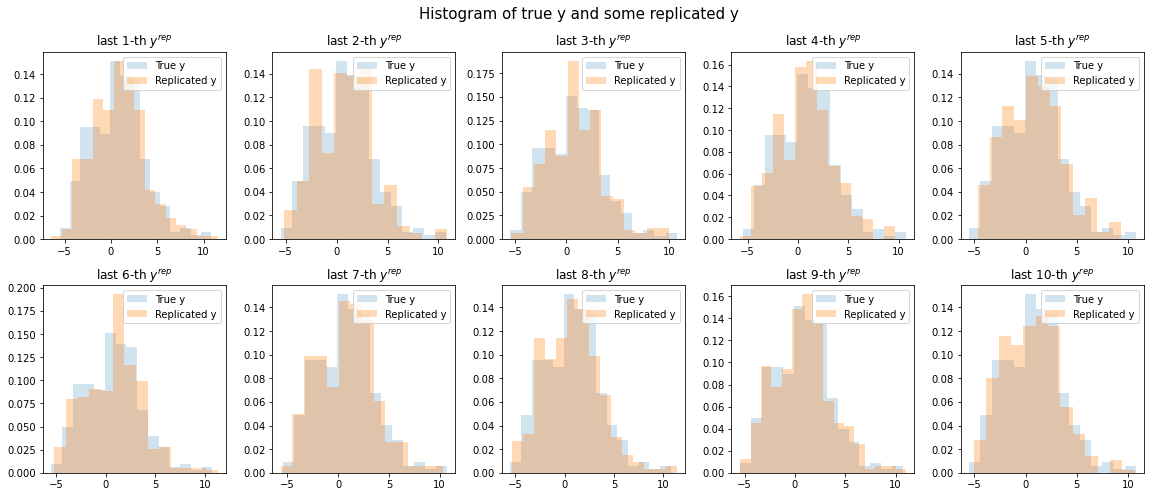

In [13]:
########################################################################
# 2. Compare the graphical plots                                       #
########################################################################
## Conduct the posterior predictive check using some test quantities T(y, theta).
plt.figure(figsize=(16, 7))
plotnm = 1
for i in range(1, 11):
    plt.subplot(2, 5, plotnm)
    plt.hist(y, bins='auto', density=True, alpha=0.2, label='True y')
    plt.hist(y_rep_samples[-i], bins='auto', density=True, alpha=0.3, label='Replicated y')
    plt.title(f'last {i}-th $y^{{rep}}$')
    plt.legend()
    plotnm += 1
plt.suptitle(f'Histogram of true y and some replicated y', fontsize=15)

plt.tight_layout()
plt.show()
# In posterior predictive check, it is often recommended to compare graphcal plots such as the distribution of y and y_rep
# The histograms which compare the true value with some y replicated
# We can see a similar trend overall.

In [12]:
########################################################################
# 3. Posterior predictive check                                        #
########################################################################
def test_quantity(X, y, beta):
    residuals = (y - X @ beta_true)
    return (residuals @ residuals) / len(y)

# 1. Compute the test statistic values for the replicated data
test_stat_rep = np.zeros(n_mcmc)
for i in range(n_mcmc):
    beta_rep = beta_samples[i]
    test_stat_rep[i] = test_quantity(X, y_rep_samples[i], beta_rep)

# 2. Compute the test statistic values for the observed data
test_stat_obs = np.zeros(n_mcmc)
for i in range(n_mcmc):
    beta_obs = beta_samples[i]
    test_stat_obs[i] = test_quantity(X, y, beta_obs)

# 3. Perform posterior predictive checks by comparing the distribution of test_stat_rep and test_stat_obs
pc = np.mean(test_stat_rep >= test_stat_obs)
print(f'Posterior predictive p-value: {pc :.3f}')

Posterior predictive p-value: 1.000


### iv) Re-do ii) and iii) using the prior in (c) instead. Discuss the results.

#### Prior on $\sigma^2_{\beta, k}$

In [14]:
########################################################################
# Run MCMC function                                                    #
########################################################################
m, d, nj, N = 30, 2, 10, 300

# Hyperparameters
hyper = dict()
hyper['m'] = 30
hyper['d'] = 2
hyper['nj'] = 10
hyper['nu'] = 3                        # df of Inv-chi2
hyper['tau2'] = 10                     # scale of Inv-chi2
hyper['xi'] = np.zeros(d)              # mean of MVN
hyper['Omega'] =  10 * np.identity(d)  # cov of MVN
hyper['rho'] = d + 1                   # df of Inv-Wishart
hyper['Psi'] = np.identity(d)          # scale matrix fo Inv-Wishart
hyper['psi2'] = 10

n_mcmc = 10000; burn_in = n_mcmc // 2
beta_samples, sig2_samples, mu_beta_samples, cov_beta_samples, y_rep_samples = mixed_effect_gibbs(X, y, hyper, n_mcmc, burn_in, False)

True values
mu_beta: [0.5 1. ]
cov_beta: 
[[2.  1.9]
 [1.9 2. ]]
sigma^2: 0.5 

The means of MCMC samples
mu_beta: [0.40207464 0.77142362]
cov_beta: 
 [[4.55200841 0.        ]
 [0.         5.26628787]]
sigma^2: 0.5782189042899708


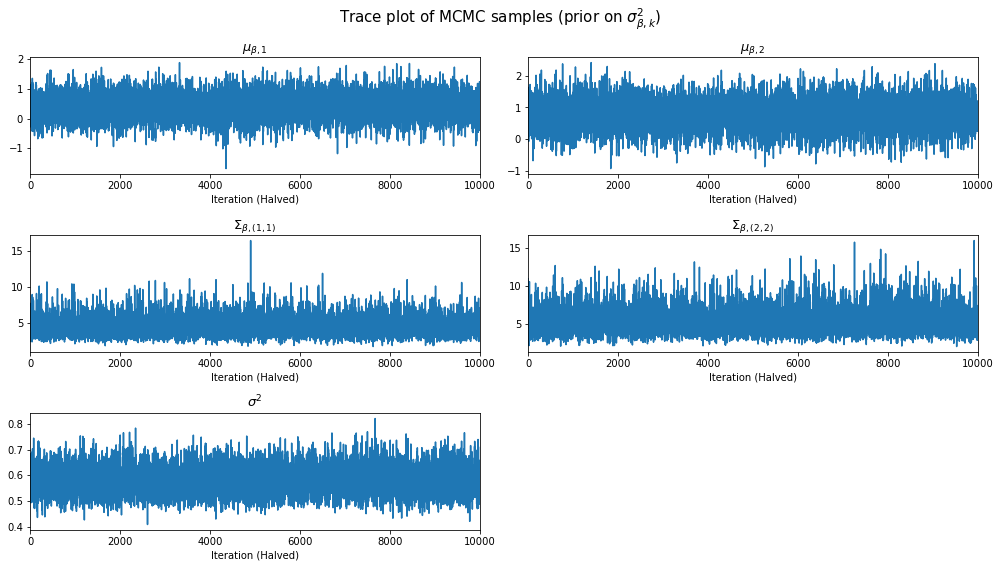

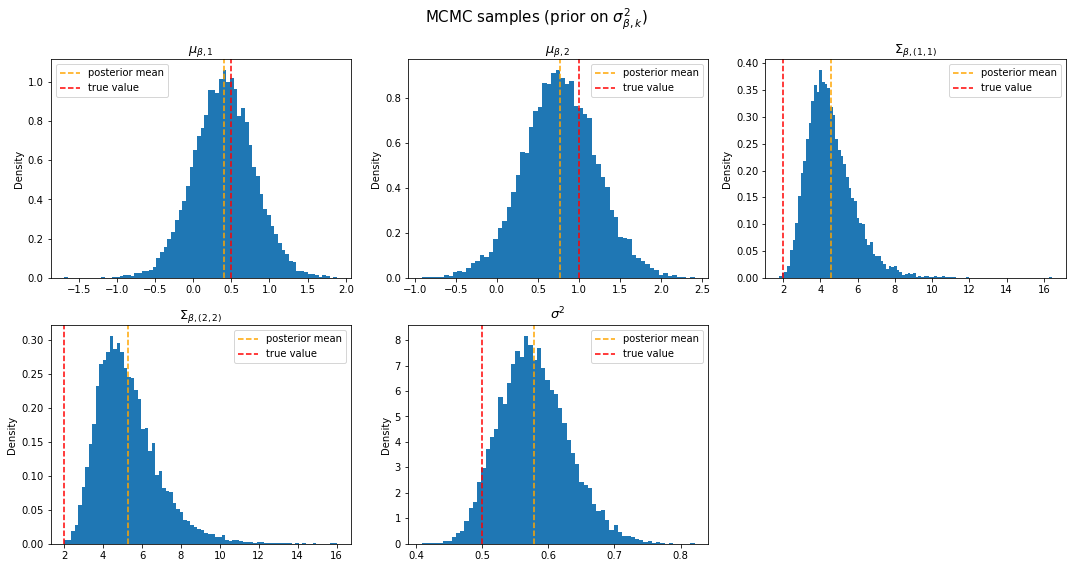

In [20]:
########################################################################
# diagnostics and histogram                                            #
########################################################################

# 1. mean
print('True values')
print(f'mu_beta: {mu_beta_true}')
print(f'cov_beta: \n{cov_beta_true}')
print(f'sigma^2: {sig2_true} \n')

print('The means of MCMC samples')
print(f'mu_beta: {np.mean(mu_beta_samples, axis=0)}')
print(f'cov_beta: \n {np.mean(cov_beta_samples, axis=0).reshape(2, 2)}')
print(f'sigma^2: {np.mean(sig2_samples, axis=0)}')

# 2. Trace plot
plt.figure(figsize=(14, 8))
plotnm = 1
for i in range(2):
    plt.subplot(3, 2, plotnm)
    plt.plot(mu_beta_samples[:, i])
    plt.xlim(0, n_mcmc)
    plt.xlabel('Iteration (Halved)')
    plt.title(f'$\\mu_{{\\beta, {i+1}}}$', fontsize=13)
    plotnm += 1

temp_nm = [f'$\\Sigma_{{\\beta, (1,1)}}$', f'$\\Sigma_{{\\beta, (2,2)}}$']
for i in range(2):
    plt.subplot(3, 2, plotnm)
    plt.plot(cov_beta_samples[:, i*3])
    plt.xlim(0, n_mcmc)
    plt.xlabel('Iteration (Halved)')
    plt.title(temp_nm[i], fontsize=13)
    plotnm += 1

plt.subplot(3, 2, plotnm)
plt.plot(sig2_samples)
plt.xlim(0, n_mcmc)
plt.xlabel('Iteration (Halved)')
plt.title(f'$\\sigma^{{2}}$', fontsize=13)

plt.suptitle(f'Trace plot of MCMC samples (prior on $\\sigma^{{2}}_{{\\beta, k}}$)', fontsize=15)
plt.tight_layout()
plt.savefig('Q1_d_2_prior_sig2_trace.png')
plt.show()

########################################################################
# Histogram                                                            #
########################################################################
plt.figure(figsize=(15, 8))
plotnm = 1
for i in range(2):
    plt.subplot(2, 3, plotnm)
    plt.hist(mu_beta_samples[:, i], bins='auto', density=True)
    plt.axvline(np.mean(mu_beta_samples, axis=0)[i], color='orange', linestyle='dashed', label='posterior mean')
    plt.axvline(mu_beta_true[i], color='red', linestyle='dashed', label='true value')
    plt.ylabel('Density')
    plt.title(f'$\\mu_{{\\beta, {i+1}}}$', fontsize=13)
    plt.legend()
    plotnm += 1

temp_nm = [f'$\\Sigma_{{\\beta, (1,1)}}$', f'$\\Sigma_{{\\beta, (2,2)}}$']
for i in range(2):
    plt.subplot(2, 3, plotnm)
    plt.hist(cov_beta_samples[:, i*3], bins='auto', density=True)
    plt.axvline(np.mean(cov_beta_samples, axis=0)[i*3], color='orange', linestyle='dashed', label='posterior mean')
    plt.axvline(cov_beta_true.flatten()[i*3], color='red', linestyle='dashed', label='true value')
    plt.ylabel('Density')
    plt.title(temp_nm[i], fontsize=13)
    plt.legend()
    plotnm += 1

plt.subplot(2, 3, plotnm)
plt.hist(sig2_samples, bins='auto', density=True)
plt.axvline(np.mean(sig2_samples), color='orange', linestyle='dashed', label='posterior mean')
plt.axvline(sig2_true, color='red', linestyle='dashed', label='true value')
plt.ylabel('Density')
plt.title(f'$\\sigma^{{2}}$', fontsize=13)
plt.legend()

plt.suptitle(f'MCMC samples (prior on $\\sigma^{{2}}_{{\\beta, k}}$)', fontsize=15)
plt.tight_layout()
plt.savefig('Q1_d_2_prior_sig2_hist.png')
plt.show()

#### Posterior predictive check

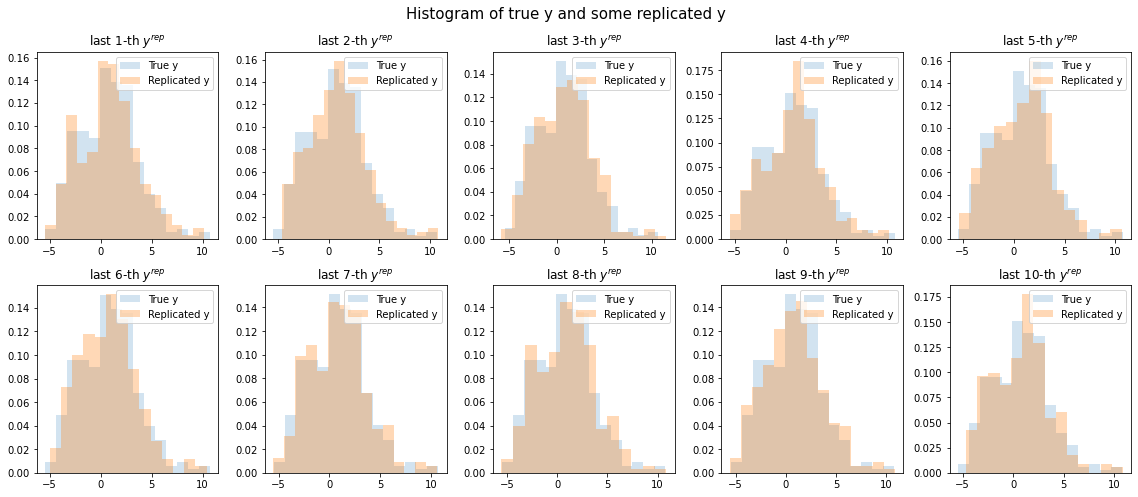

In [23]:
########################################################################
# 2. Compare the graphical plots                                       #
########################################################################
## Conduct the posterior predictive check using some test quantities T(y, theta).
plt.figure(figsize=(16, 7))
plotnm = 1
for i in range(1, 11):
    plt.subplot(2, 5, plotnm)
    plt.hist(y, bins='auto', density=True, alpha=0.2, label='True y')
    plt.hist(y_rep_samples[-i], bins='auto', density=True, alpha=0.3, label='Replicated y')
    plt.title(f'last {i}-th $y^{{rep}}$')
    plotnm += 1
    plt.legend()
    
plt.suptitle(f'Histogram of true y and some replicated y', fontsize=15)
plt.tight_layout()
plt.show()
# In posterior predictive check, it is often recommended to compare graphcal plots such as the distribution of y and y_rep
# The histograms which compare the true value with some y replicated
# We can see a similar trend overall.

In [22]:
########################################################################
# 3. Posterior predictive check                                        #
########################################################################
def test_quantity(X, y, beta):
    residuals = (y - X @ beta_true)
    return (residuals @ residuals) / len(y)

# 1. Compute the test statistic values for the replicated data
test_stat_rep = np.zeros(n_mcmc)
for i in range(n_mcmc):
    beta_rep = beta_samples[i]
    test_stat_rep[i] = test_quantity(X, y_rep_samples[i], beta_rep)

# 2. Compute the test statistic values for the observed data
test_stat_obs = np.zeros(n_mcmc)
for i in range(n_mcmc):
    beta_obs = beta_samples[i]
    test_stat_obs[i] = test_quantity(X, y, beta_obs)

# 3. Perform posterior predictive checks by comparing the distribution of test_stat_rep and test_stat_obs
pc = np.mean(test_stat_rep >= test_stat_obs)
print(f'Posterior predictive p-value: {pc :.3f}')

Posterior predictive p-value: 1.000
